# AudioCLIP: Extending CLIP to Image, Text and Audio

### Andrey Guzhov, Federico Raue, J¨orn Hees, and Andreas Dengel

## Name: Mayukh Maity(220150033)

## Course: DA 323

# Motivation

Personally, as we were looking at multiple modalities, and we also went through the CLIP architecture in class itself, the question of whether three modalities, namely image, text and audio could be trained simultaneously seemed very interesting to me, and this paper did exactly that, it expanded CLIP into the domain of audio, this paper now can look at multiple cross-modality zero shot applications like image-text, image-audio and audio-text.

## How it connects with present and past work done in Multimodal Learning.

### Early Approaches (2010-2015)
The initial phase of multimodal learning focused on developing models for individual modalities. Researchers created sophisticated architectures for processing text (like BERT and GPT), images (CNNs like ResNet), and audio (ESResNeXt) separately. These unimodal approaches achieved good results but operated individually.

### Bimodal Integration (2016-2020)
Models like VGGish and SoundNet showed the potential of audio-visual learning, while image captioning systems showed promising results in connecting visual and textual information.

### Contrastive Learning Breakthrough (2021)
The introduction of OpenAI's CLIP (Contrastive Language-Image Pre-training) in early 2021 was a breakthrough. By training on 400 million image-text pairs using contrastive learning, CLIP demonstrated remarkable zero-shot capabilities, allowing it to generalize to unseen datasets without additional fine-tuning.

### Expansion to Three Modalities (2021-Present)
AudioCLIP emerged in mid-2021 as a natural extension of the CLIP framework, incorporating audio as a third modality. By integrating the ESResNeXt audio model with CLIP's existing text and image capabilities, AudioCLIP created a unified embedding space where all three modalities could interact.

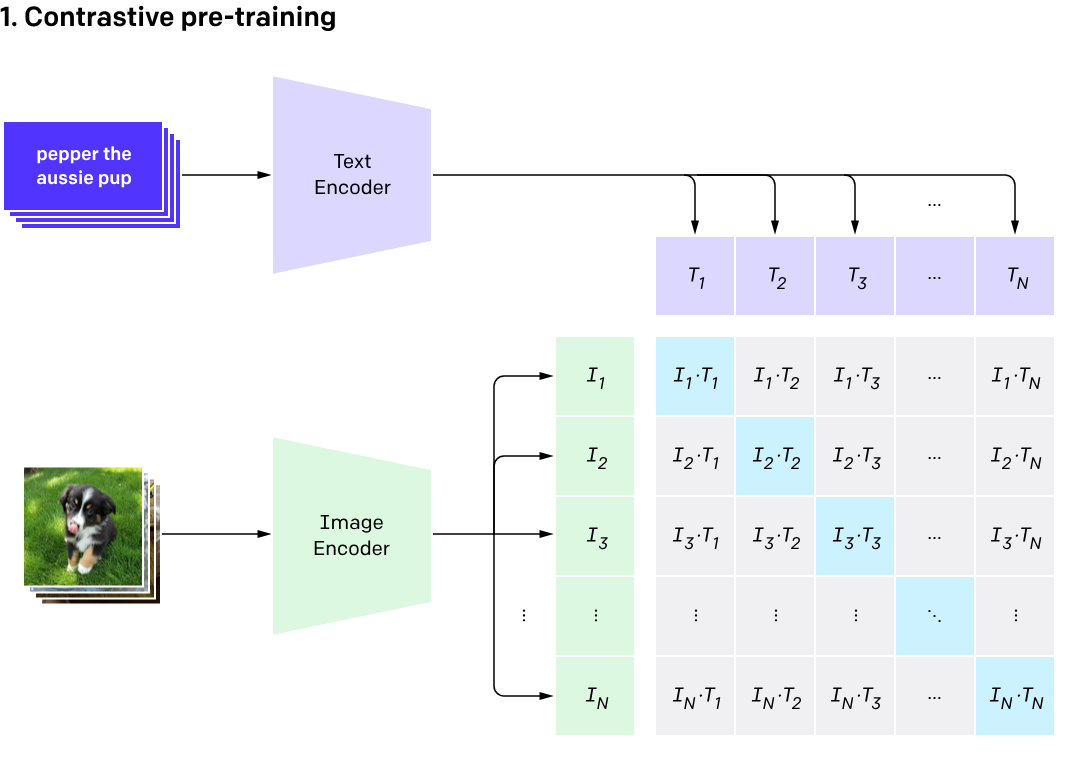

CLIP architecture

# Architecture of AudioCLIP

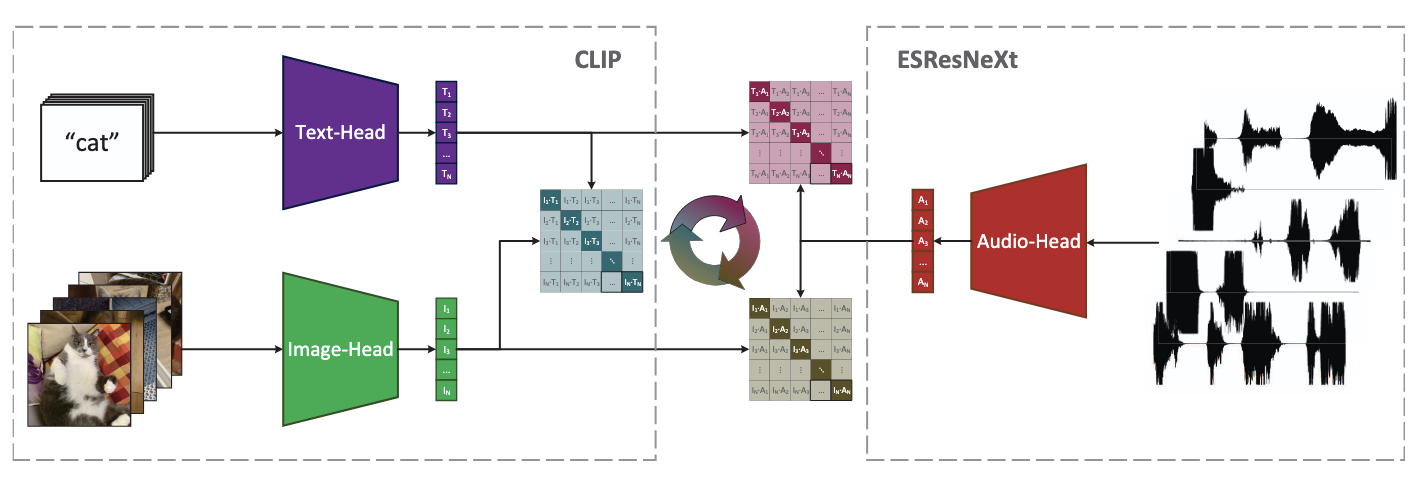

The AudioCLIP architecture

AudioCLIP represents an interesting hybrid architecture that combines three modalities into a framework. The model consists of three components:

1. Visual Encoder
The visual encoder utilizes a ResNet-based architecture derived from the original CLIP model. This component processes images and extracts high-level visual features that capture objects, scenes, textures, and other visual elements. The visual encoder culminates in a self-attention layer that produces both a visual representation and an audio-aware feature map.

2. Text Encoder
For processing textual information, AudioCLIP uses the transformer-based text encoder from CLIP. This component handles natural language input, encoding meaning and contextual relationships between words. The text encoder allows the model to understand descriptive labels, categories, and free-form textual queries.

3. Audio Encoder
The audio encoder incorporates the ESResNeXt model, a specialized architecture for sound processing. This component analyzes audio spectrograms to identify patterns associated with different sounds, from natural environments to human speech and music. The audio encoder enables the model to recognize and classify a wide range of acoustic events.

### Data Augmentation

To combat overfitting due to limited audio samples (e.g., UrbanSound8K, ESC-50), AudioCLIP applies the following augmentations:

---

#### Time Scaling
  Randomly stretches or compresses audio (affects duration and pitch).  
  Efficient alternative to time-stretch + pitch shift.  
  Scaling factor: **[-1.5, 1.5]**

---

#### Time Inversion  
  Flips audio along the time axis (like horizontal image flip).  
  Applied with **50% probability**.

---

#### Crop & Padding
  Adjusts audio length via random cropping or zero-padding.  
  Ensures uniform input length.  
  Uses **center crop** during evaluation.

---

#### Additive Noise
  Adds **Gaussian noise** to improve robustness.  
  SNR randomly sampled from **[10 dB, 120 dB]**, with **25% probability**.



## Training Process Overview

The AudioCLIP training was divided into sequential steps to ensure proper integration of the three modalities (text, image, and audio):

#### Model Initialization:
The process starts with a ResNet-based CLIP model pre-trained on its text-image dataset, combined with an ESResNeXt audio model initialized with ImageNet weights.

---

#### Audio-Head Pre-Training:
Before full integration, the audio component goes two preparation phases:
Standalone Pre-training: The ESResNeXt model is trained on AudioSet for an extended period (30 epochs instead of the original 5), which significantly improved performance (mAP increased from 28.17% to 34.14%).

---

#### Cooperative Pre-training:
The pre-trained audio-head is modified by replacing its classification layer with a randomly initialized one matching CLIP's embedding space size (1024). During this phase, the text and image heads is kept frozen, acting as 'teachers' in a multi-modal knowledge distillation setup.

---

#### Full AudioCLIP Training:
All three subnetworks (text, image, and audio heads) are jointly fine-tuned on the AudioSet dataset using audio snippets, corresponding to video frames, and text labels.

---

#### Downstream Task Fine-Tuning:
The audio head was further fine-tuned on target datasets (UrbanSound8K and ESC-50) in a bimodal manner (audio and text).

## Loss function

The overall loss function used in AudioCLIP is:

$$
\mathcal{L} = \mathcal{L}_{\text{text-image}} + \mathcal{L}_{\text{text-audio}} + \mathcal{L}_{\text{image-audio}}
$$

Each of the components is a **symmetric cross-entropy loss** over cosine similarities:

$$
\mathcal{L}_{\text{text-image}} = \frac{1}{2} \left( \mathcal{L}_{t \rightarrow i} + \mathcal{L}_{i \rightarrow t} \right)
$$

Where the **directional loss** (e.g., text-to-image) is computed as:

$$
\mathcal{L}_{t \rightarrow i} = -\frac{1}{N} \sum_{i=1}^{N} \log \frac{\exp(\text{sim}(t_i, i_i) / \tau)}{\sum_{j=1}^{N} \exp(\text{sim}(t_i, i_j) / \tau)}
$$

The terms are defined as follows:

- $\text{sim}(a, b)$ is the **cosine similarity** between embeddings
- $\tau$ is the **temperature parameter**
- $N$ is the **batch size**
- $t_i$ and $i_i$ are the **text and image embeddings** for the $i$-th pair

The same symmetric structure applies to:

- $\mathcal{L}_{\text{text-audio}}$
- $\mathcal{L}_{\text{image-audio}}$


# Results

## ESResNeXt Training Improvement

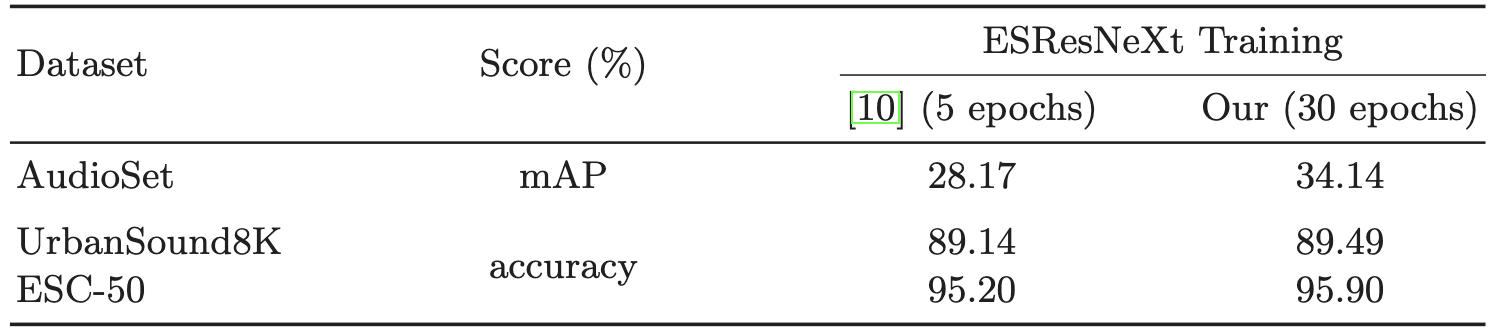

*The extra training boosts performance across all datasets, especially improving mAP (mean average precision) on AudioSet. It shows that longer training brings stronger audio representations, which also help downstream tasks like classification.*

## Partial vs Full Training of AudioCLIP

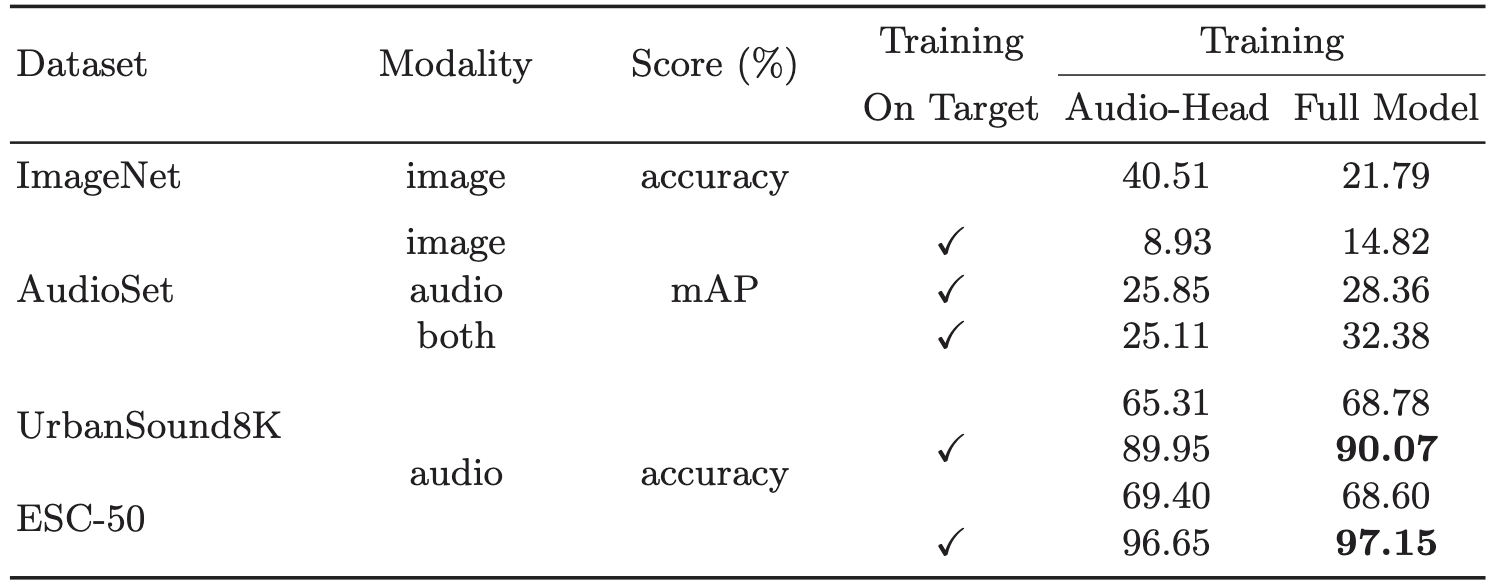

*This table compares partial training (only the audio encoder is trained) vs full training (all three modalities trained together). Full training generally improves performance, especially for multimodal classification on AudioSet and fine-tuned accuracy on ESC-50 and UrbanSound8K. The slight drop on ImageNet is likely due to domain mismatch, showing trade-offs when training on different distributions.*

## Comparison with Other Models (ESC-50 & UrbanSound8K)

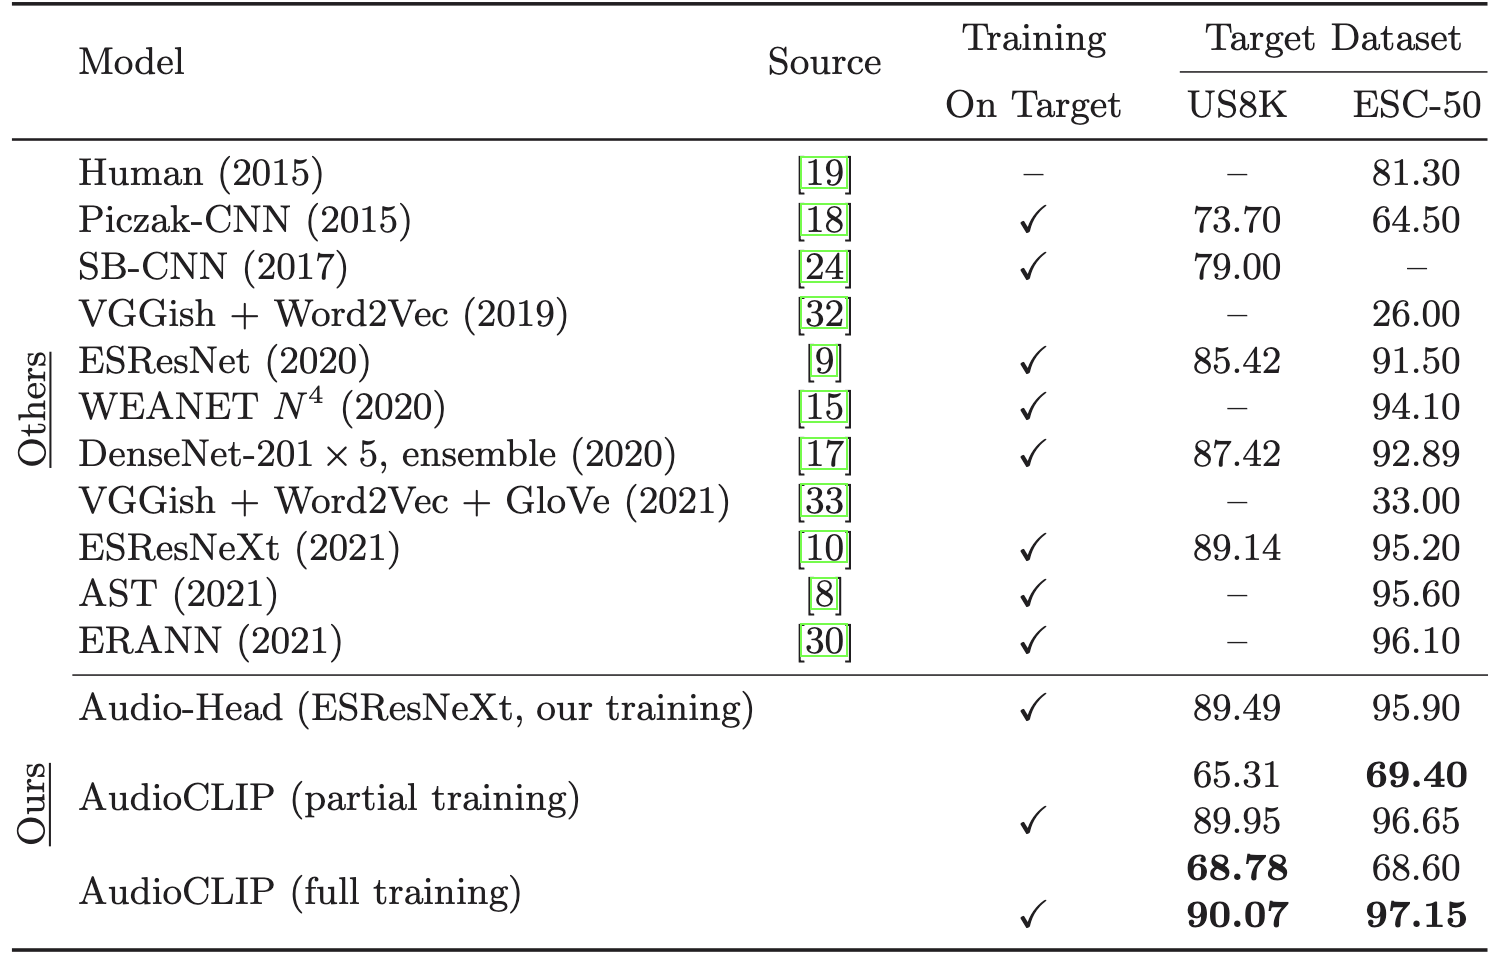

*AudioCLIP sets a new state of the art in sound classification. It achieves 97.15% on ESC-50 and 90.07% on UrbanSound8K - beating previous top models.*

## Querying Performance (Cross-Modal Retrieval)

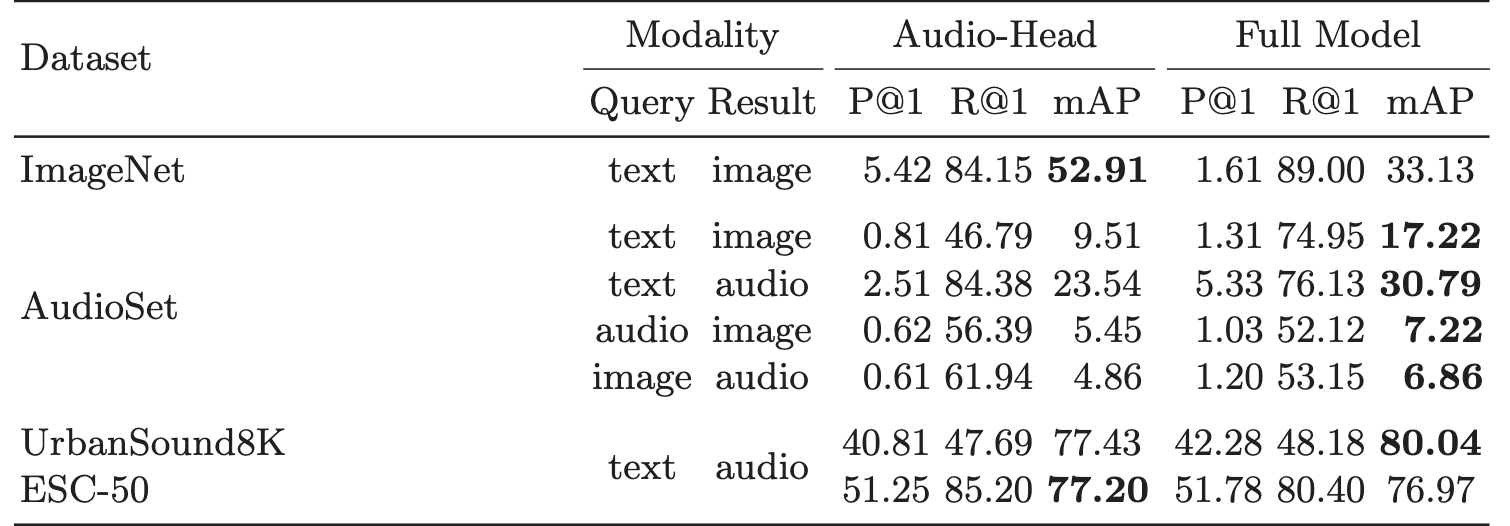

*AudioCLIP retrieves relevant content across different modalities — like finding an image or audio clip from a text query. Full training boosts performance across most tasks, particularly in text-to-audio and audio-to-image retrieval.*

# Code Demonstrations

## Classification
This task is a specific case of a more general one, which is [querying](#Querying).
However, this setup is mentioned as a standalone because it demonstrates clearly how to perform usual classification (including [zero-shot inference](https://github.com/openai/CLIP#zero-shot-prediction)) using AudioCLIP.

### Audio

In [ ]:
print('\t\tFilename, Audio\t\t\tTextual Label (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_audio_text.softmax(dim=1)
for audio_idx in range(len(paths_to_audio)):
    # acquire Top-3 most similar results
    conf_values, ids = confidence[audio_idx].topk(3)

    # format output strings
    query = f'{os.path.basename(paths_to_audio[audio_idx]):>30s} ->\t\t'
    results = ', '.join([f'{LABELS[i]:>15s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

		Filename, Audio			Textual Label (Confidence)

 alarm_clock_3-120526-B-37.wav ->		    alarm clock (99.87%),        car horn (00.09%),    thunderstorm (00.02%)
     car_horn_1-24074-A-43.wav ->		       car horn (96.12%),    thunderstorm (02.17%),        coughing (01.14%)
           cat_3-95694-A-5.wav ->		            cat (99.96%),        car horn (00.04%),    thunderstorm (00.00%)
     coughing_1-58792-A-24.wav ->		       coughing (99.36%),        car horn (00.56%),             cat (00.03%)
     thunder_3-144891-B-19.wav ->		   thunderstorm (99.36%),        car horn (00.38%),             cat (00.17%)


## Querying

### Audio by Text

In [ ]:
print('\t\tTextual Label\t\tFilename, Audio (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_audio_text.softmax(dim=0)
for label_idx in range(len(LABELS)):
    # acquire Top-2 most similar results
    conf_values, ids = confidence[:, label_idx].topk(2)

    # format output strings
    query = f'{LABELS[label_idx]:>25s} ->\t\t'
    results = ', '.join([f'{os.path.basename(paths_to_audio[i]):>30s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

		Textual Label		Filename, Audio (Confidence)

                      cat ->		           cat_3-95694-A-5.wav (99.25%),  alarm_clock_3-120526-B-37.wav (00.34%)
             thunderstorm ->		     thunder_3-144891-B-19.wav (98.60%),      car_horn_1-24074-A-43.wav (00.76%)
                 coughing ->		     coughing_1-58792-A-24.wav (99.78%),      car_horn_1-24074-A-43.wav (00.19%)
              alarm clock ->		 alarm_clock_3-120526-B-37.wav (100.00%),      thunder_3-144891-B-19.wav (00.00%)
                 car horn ->		     car_horn_1-24074-A-43.wav (89.28%),  alarm_clock_3-120526-B-37.wav (06.50%)


### Images by Text

In [ ]:
print('\tTextual Label\t\t\tFilename, Image (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_image_text.softmax(dim=0)
for label_idx in range(len(LABELS)):
    # acquire Top-3 most similar results
    conf_values, ids = confidence[:, label_idx].topk(3)

    # format output strings
    query = f'{LABELS[label_idx]:>20s} ->\t\t'
    results = ', '.join([f'{os.path.basename(paths_to_images[i]):>20s} ({v:>06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

	Textual Label			Filename, Image (Confidence)

                 cat ->		           cat_2.jpg (65.46%),            cat_1.jpg (34.24%),       coughing_1.jpg (00.12%)
        thunderstorm ->		     lightning_2.jpg (86.26%),      lightning_1.jpg (13.72%),            cat_2.jpg (00.00%)
            coughing ->		      coughing_2.jpg (49.51%),       coughing_1.jpg (38.11%),            cat_2.jpg (09.61%)
         alarm clock ->		         clock_1.jpg (85.85%),          clock_2.jpg (14.01%),       coughing_1.jpg (00.08%)
            car horn ->		          cars_2.jpg (36.45%),           cars_1.jpg (24.53%),          clock_1.jpg (18.69%)


### Audio by Images

In [ ]:
print('\tTextual Label\t\t\tFilename, Image (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_audio_image.softmax(dim=0)
for image_idx in range(len(paths_to_images)):
    # acquire Top-2 most similar results
    conf_values, ids = confidence[:, image_idx].topk(2)

    # format output strings
    query = f'{os.path.basename(paths_to_images[image_idx]):>25s} ->\t\t'
    results = ', '.join([f'{os.path.basename(paths_to_audio[i]):>30s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

	Textual Label			Filename, Image (Confidence)

               cars_1.jpg ->		     car_horn_1-24074-A-43.wav (63.43%),  alarm_clock_3-120526-B-37.wav (19.15%)
               cars_2.jpg ->		     car_horn_1-24074-A-43.wav (92.30%),  alarm_clock_3-120526-B-37.wav (06.56%)
                cat_1.jpg ->		           cat_3-95694-A-5.wav (99.99%),      car_horn_1-24074-A-43.wav (00.00%)
                cat_2.jpg ->		           cat_3-95694-A-5.wav (99.80%),      coughing_1-58792-A-24.wav (00.16%)
              clock_1.jpg ->		 alarm_clock_3-120526-B-37.wav (99.12%),      car_horn_1-24074-A-43.wav (00.67%)
              clock_2.jpg ->		 alarm_clock_3-120526-B-37.wav (97.73%),      thunder_3-144891-B-19.wav (01.26%)
           coughing_1.jpg ->		     coughing_1-58792-A-24.wav (76.45%),            cat_3-95694-A-5.wav (18.38%)
           coughing_2.jpg ->		     coughing_1-58792-A-24.wav (83.47%),      thunder_3-144891-B-19.wav (05.51%)
          lightning_1.jpg ->		     thunder_3-144891-B-19.wav (98.

### Images by Audio

In [ ]:
print('\tTextual Label\t\t\tFilename, Image (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_audio_image.softmax(dim=1)
for audio_idx in range(len(paths_to_audio)):
    # acquire Top-3 most similar results
    conf_values, ids = confidence[audio_idx].topk(3)

    # format output strings
    query = f'{os.path.basename(paths_to_audio[audio_idx]):>30s} ->\t\t'
    results = ', '.join([f'{os.path.basename(paths_to_images[i]):>15s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

	Textual Label			Filename, Image (Confidence)

 alarm_clock_3-120526-B-37.wav ->		    clock_1.jpg (82.85%),     clock_2.jpg (10.75%),      cars_2.jpg (05.61%)
     car_horn_1-24074-A-43.wav ->		     cars_2.jpg (97.17%),      cars_1.jpg (01.44%),     clock_1.jpg (00.69%)
           cat_3-95694-A-5.wav ->		      cat_1.jpg (88.33%),       cat_2.jpg (11.40%),  coughing_1.jpg (00.22%)
     coughing_1-58792-A-24.wav ->		 coughing_1.jpg (69.95%),  coughing_2.jpg (20.01%),      cars_2.jpg (03.78%)
     thunder_3-144891-B-19.wav ->		lightning_1.jpg (59.54%), lightning_2.jpg (36.54%),      cars_2.jpg (01.90%)


# Conclusion

AudioCLIP takes CLIP and enhances it by adding audio. Through smart training, data augmentations, it achieves state of the art results in sound classification and gives a baseline for cross-modal retrieval between text, images, and audio.

Whether one is searching for a sound with an image, or describing a sound with text, AudioCLIP shows that multimodal learning is very possible.


# Reflections

## Initialization of Audio-Head with ImageNet weights

The first thing that was the most surprising to me was the initialization of the audio-head's weights using a model pre-trained on ImageNet. ImageNet is a dataset of visual images, and while the audio input is transformed into a time-frequency representation, using weights learned from classifying objects in photographs as a starting point for processing sounds via a CNN backbone is quite counter-intuitive. It showed to me the power of transfer learning and how weights trained on a different modality can still have coherence and can be fine tuned on a different modality.

## Jump in audio modality classification performance due to multimodality
Another aspect that intrigued me is the jump in performance achieved by simply adding the audio modality to the existing CLIP structure and training it effectively. The fact that AudioCLIP achieved better results and set new baselines on environmental sound classification tasks, simply by becoming multimodal, is very telling in the usefulness of multimodality.

# Improvement

## Evaluation on a wider variety of datasets and tasks:

While performance on environmental sound classification is strong, evaluating AudioCLIP on more diverse audio challenges (e.g., speech commands, music genre classification, audio captioning, sound event detection) could provide a more general view of its performance.

## Changing backbones to more powerful networks:
The current architecture uses a ResNet-based image head and an ESResNeXt audio head. Using more advanced or recently developed network architectures for these heads, such as Vision Transformers (ViT) which were considered but not chosen for the hybrid due to computational constraints, could lead to performance gains.

# References

## Papers

- **Guzhov, A., Raue, F., Hees, J., Dengel, A.**  
  *AudioCLIP: Extending CLIP to Image, Text and Audio⋆.*  
  arXiv preprint [arXiv:2106.13043v1](https://arxiv.org/abs/2106.13043) (2021)

- **Alayrac, J.B., et al.**  
  *Self-supervised multimodal versatile networks.*  
  arXiv preprint [arXiv:2006.16228](https://arxiv.org/abs/2006.16228) (2020)

- **Islam, M.T., Nirjon, S.**  
  *Soundsemantics: Exploiting semantic knowledge in text for embedded acoustic event classification.*  
  In: *Proceedings of the 18th International Conference on Information Processing in Sensor Networks*, pp. 217–228 (2019)

- **Radford, A., et al.**  
  *Learning transferable visual models from natural language supervision.*  
  (2021) – [CLIP paper](https://openai.com/research/clip)

- **Gemmeke, J.F., et al.**  
  *AudioSet: An ontology and human-labeled dataset for audio events.*  
  In: *2017 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP)*, pp. 776–780. IEEE (2017)

- **Gong, Y., Chung, Y.A., Glass, J.**  
  *AST: Audio Spectrogram Transformer.*  
  (2021) – [arXiv link](https://arxiv.org/abs/2104.01778)


## Repos

[AudioCLIP](https://github.com/AndreyGuzhov/AudioCLIP)